In [1]:
# Change working directory
%cd ..

f:\DS Lab\OT\KPG_GWB


C:\Users\ngtdu\AppData\Roaming\Python\Python39\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import json
import pandas as pd
import numpy as np
import scipy
import os
import ot
from optimal_transport.models import KeypointGW, GW_Barycenter, GW, KPG_RL_GW
from optimal_transport.experiments import OutlierRate, ClusterMismatch, Dimensionality
from typing import Tuple, Optional, List, Union, Dict

# To make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns

Using TensorFlow backend.


In [3]:
#@title Dimensionality
n_keypoints = 4
k = 4

models = {
    "KeypointGW": KeypointGW(loss_fun='square_loss', num_free_barycenters=n_keypoints, n_clusters=n_keypoints, sinkhorn_reg=0.05, temperature=0.05, alpha=0.2, tol=1e-5, max_iters=150, sinkhorn_max_iters=1000),
    "GW_Barycenter": GW_Barycenter(N=n_keypoints, loss_fun='square_loss', max_iters=10000),
    "GW": GW(loss_fun='square_loss', max_iters=10000),
    "KPG_RL_GW": KPG_RL_GW(cost_function='L2', algorithm = "lp", max_iteration=1000),
}

delta = 1
mean_s = np.concatenate([np.random.uniform(1, 2, size=k)[:, None], 
                        np.arange((-k // 2 + 1)*delta, (k // 2 + 1)*delta, delta)[:, None],
                        np.random.rand(k, 5-2)], axis=1)
# mean_t = np.concatenate([np.random.uniform(1, 2, size=k)[:, None], 
#                         np.random.uniform(2, 3, size=k)[:, None],  
#                         np.arange((-k // 2 + 1)*delta, (k // 2 + 1)*delta, delta)[:, None],
#                         np.random.uniform(3, 4, size=k)[:, None], 
#                         np.random.uniform(4, 6, size=k)[:, None]], axis=1) 
mean_t = mean_s.copy()
mean_t[:, 0] = -np.random.uniform(1, 2, size=k)


experiment = Dimensionality(model=models, log_dir="logs")
results = experiment(
    noise_level=1, max_projected_dim=100, freq_projected_dim=5, hyperplane_dim=5,
    n_components=k, cluster_samples=100, n_keypoints=n_keypoints, 
    src_properties={"means": mean_s, "cov_scale": 0.1},
    trg_properties={"means": mean_t, "cov_scale": 0.1}
)

optimal
optimal
optimal
Dimension: 5, Accuracy: {'KeypointGW': 0.25, 'GW_Barycenter': 0.3825, 'GW': 0.28, 'KPG_RL_GW': 0.73}, Runtime: {'KeypointGW': 26.19532537460327, 'GW_Barycenter': 0.638446569442749, 'GW': 1.380767583847046, 'KPG_RL_GW': 43.68395638465881}
optimal
optimal
optimal
Dimension: 10, Accuracy: {'KeypointGW': 0.73, 'GW_Barycenter': 0.37, 'GW': 0.335, 'KPG_RL_GW': 0.7225}, Runtime: {'KeypointGW': 69.69147300720215, 'GW_Barycenter': 0.4740300178527832, 'GW': 0.9702627658843994, 'KPG_RL_GW': 39.156272172927856}


Noise ratio: 0.0, Accuracy: {'KeypointGW': 1.0, 'GW_Barycenter': 1.0, 'GW': 0.4975, 'KPG_RL_GW': 1.0}, Runtime: {'KeypointGW': 2.8176190853118896, 'GW_Barycenter': 0.6471621990203857, 'GW': 1.0607244968414307, 'KPG_RL_GW': 26.438244342803955}
Noise ratio: 0.1, Accuracy: {'KeypointGW': 0.9975, 'GW_Barycenter': 0.985, 'GW': 0.0075, 'KPG_RL_GW': 1.0}, Runtime: {'KeypointGW': 1.5207159519195557, 'GW_Barycenter': 0.16565322875976562, 'GW': 0.671271562576294, 'KPG_RL_GW': 25.11180591583252}
Noise ratio: 0.2, Accuracy: {'KeypointGW': 1.0, 'GW_Barycenter': 0.995, 'GW': 0.01, 'KPG_RL_GW': 1.0}, Runtime: {'KeypointGW': 1.271397352218628, 'GW_Barycenter': 0.15156078338623047, 'GW': 0.5093710422515869, 'KPG_RL_GW': 26.55505657196045}
Noise ratio: 0.30000000000000004, Accuracy: {'KeypointGW': 0.9925, 'GW_Barycenter': 0.835, 'GW': 0.49, 'KPG_RL_GW': 0.9925}, Runtime: {'KeypointGW': 3.551088571548462, 'GW_Barycenter': 64.97204899787903, 'GW': 1.3947632312774658, 'KPG_RL_GW': 56.52364373207092}
Noise 

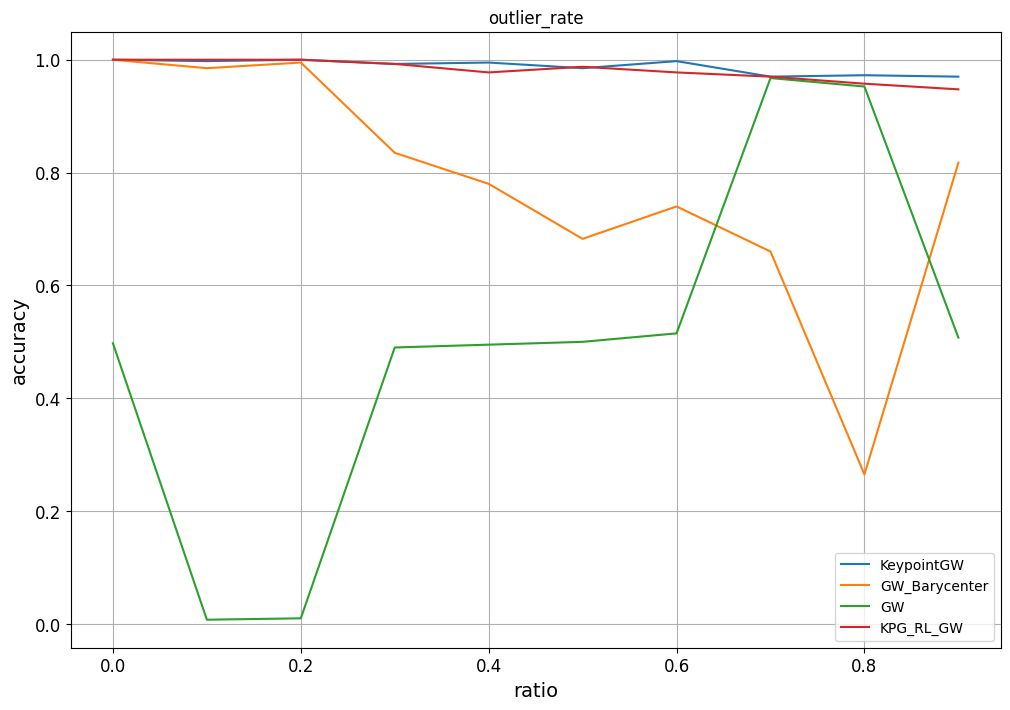

In [ ]:
#@title Outlier rate
n_keypoints = 4
d = 30
k = 4
models = {
    "KeypointGW": KeypointGW(loss_fun='square_loss', num_free_barycenters=n_keypoints, n_clusters=n_keypoints, sinkhorn_reg=0.05, temperature=0.05, alpha=0.2, tol=1e-9, max_iters=1000, sinkhorn_max_iters=100),
    "GW_Barycenter": GW_Barycenter(N=n_keypoints, loss_fun='square_loss', max_iters=10000, log=False),
    "GW": GW(loss_fun='square_loss', max_iters=2000),
    "KPG_RL_GW": KPG_RL_GW(cost_function='L2', algorithm = "lp", max_iteration=1000),
}

delta = 1
mean_s = np.concatenate([np.random.uniform(1, 2, size=k)[:, None], 
                        np.arange((-k // 2 + 1)*delta, (k // 2 + 1)*delta, delta)[:, None], 
                        np.random.rand(k, d-2)], axis=1)
mean_t = mean_s.copy()
mean_t[:, 0] = -np.random.uniform(3, 4, size=k)

experiment = OutlierRate(model=models, log_dir="logs")
results = experiment(max_noise_ratio=1, freq_noise_ratio=0.1, hyperplane_dim=d, 
                     cluster_samples=100, n_keypoints=n_keypoints, n_components=k,
                     src_properties={"means": mean_s, "cov_scale": 0.1},
                     trg_properties={"means": mean_t, "cov_scale": 0.1}
                    )

Number of source components: 2, Accuracy: {'KeypointGW': 0.01, 'GW_Barycenter': 0.1, 'GW': 0.1, 'KPG_RL_GW': 0.01}, Runtime: {'KeypointGW': 55.09912872314453, 'GW_Barycenter': 90.8089702129364, 'GW': 2.611990451812744, 'KPG_RL_GW': 55.51902794837952}
Number of source components: 3, Accuracy: {'KeypointGW': 0.01, 'GW_Barycenter': 0.1, 'GW': 0.09666666666666666, 'KPG_RL_GW': 0.013333333333333334}, Runtime: {'KeypointGW': 104.06235599517822, 'GW_Barycenter': 1.0929992198944092, 'GW': 2.8880486488342285, 'KPG_RL_GW': 89.11312246322632}
Number of source components: 4, Accuracy: {'KeypointGW': 0.01, 'GW_Barycenter': 0.05, 'GW': 0.105, 'KPG_RL_GW': 0.0225}, Runtime: {'KeypointGW': 120.4065568447113, 'GW_Barycenter': 117.06308484077454, 'GW': 3.1418848037719727, 'KPG_RL_GW': 136.82900047302246}
Number of source components: 5, Accuracy: {'KeypointGW': 0.208, 'GW_Barycenter': 0.094, 'GW': 0.094, 'KPG_RL_GW': 0.036}, Runtime: {'KeypointGW': 94.98637294769287, 'GW_Barycenter': 0.9289038181304932, 

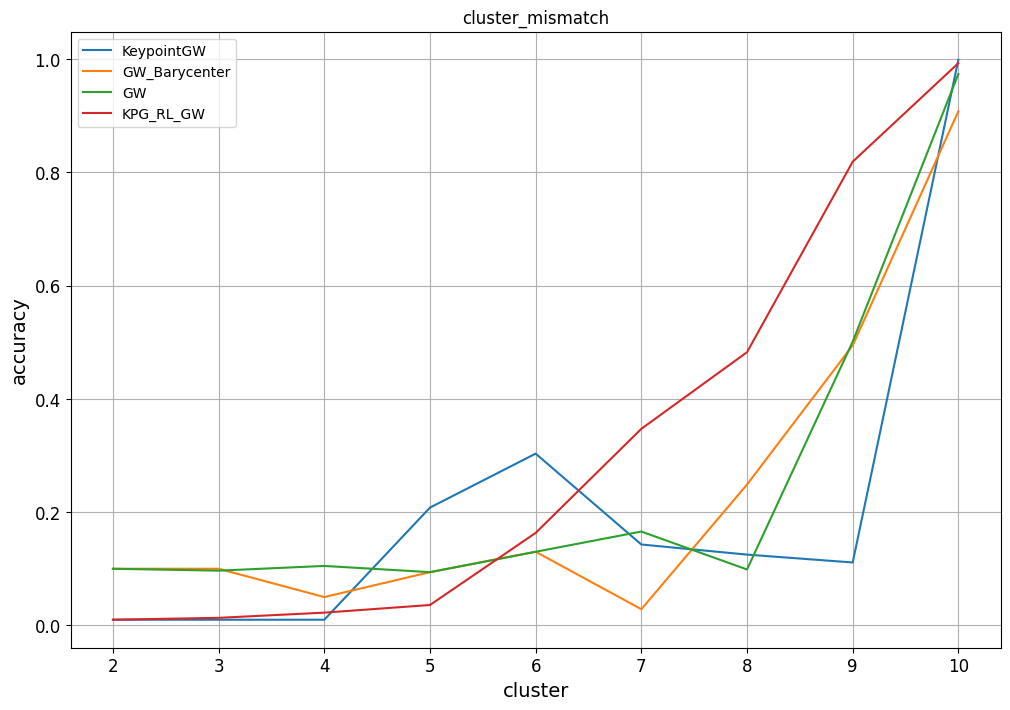

In [ ]:
#@title ClusterMismatch
n_anchors = 4
n_keypoints = 10
d = 30
k = 10
models = {
    "KeypointGW": KeypointGW(loss_fun='square_loss', num_free_barycenters=n_keypoints, n_clusters=n_keypoints, sinkhorn_reg=0.05, temperature=0.05, alpha=0.2, tol=1e-9, max_iters=1000, sinkhorn_max_iters=1000),
    "GW_Barycenter": GW_Barycenter(N=n_keypoints, loss_fun='square_loss', max_iters=10000, log=False),
    "GW": GW(loss_fun='square_loss', max_iters=2000),
    "KPG_RL_GW": KPG_RL_GW(cost_function='L2', algorithm = "sinkhorn", max_iteration=1000),
}

delta = 1
mean_s = np.concatenate([np.random.uniform(1, 2, size=k)[:, None], 
                        np.arange((-k // 2 + 1)*delta, (k 
                                                        // 2 + 1)*delta, delta)[:, None], 
                        np.random.rand(k, d-2)], axis=1)
mean_t = mean_s.copy()
mean_t[:, 0] = -np.random.uniform(1, 2, size=k)

experiment = ClusterMismatch(model=models, log_dir="logs")
results = experiment(min_source_components=2, freq_components=1, target_components=k, 
                    hyperplane_dim=d, cluster_samples=100, n_keypoints=n_keypoints,
                    src_properties={"means": mean_s, "cov_scale": 0.1},
                    trg_properties={"means": mean_t, "cov_scale": 0.1},
                    )